In [1]:
import logging
import json
import sys
from collections import defaultdict
from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import medleydb_instruments as mdb
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, ExactMatch, F1Score, Precision, Recall, Specificity

from musedetect.data import MedleyDBDataset, MedleyDBPreprocessor, get_all_instruments, train_test_split
from musedetect.data.preprocess_transforms import MFCCTransform
from musedetect.eval import compute_metrics
from musedetect.models import CnnAudioNet
from musedetect.training import FocalLossWithLogits, autodetect_device, train
from musedetect.data.custom_multitrack import LocalMultiTrack


/home/tau/acisse/miniforge3/envs/musedetect310/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# Set path to MixingSecrets tracks
MS_PATH = Path("/scratch/acisse/MedleyDB_Format/Modified_MIX/")
MS_PATH_TEST = Path("/scratch/acisse/processed_path")

/tmp/ipykernel_977717/3185852744.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


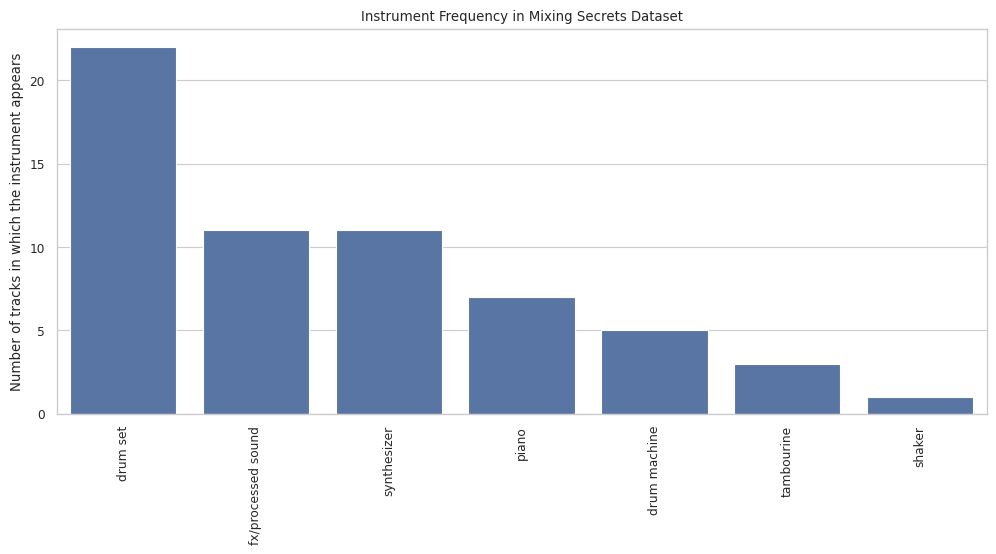

In [3]:
list_track_names = [d.stem for d in MS_PATH.glob("[!._]*") if d.is_dir()]
dataset = [LocalMultiTrack(MS_PATH / track_name) for track_name in list_track_names]


new_dataset = [track for track in dataset if not track.has_bleed]

instruments = defaultdict(lambda: 0)
for track in new_dataset:
    for instrument in track._parse_instruments():
        normalized = instrument.strip().lower()
        instruments[normalized] += 1

instruments = dict(sorted(instruments.items(), key=lambda item: item[1], reverse=True))

sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.figure(figsize=(12, 5))
g = sns.barplot(x=list(instruments.keys()), y=np.fromiter(instruments.values(), dtype=int))
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.ylabel("Number of tracks in which the instrument appears")
plt.title("Instrument Frequency in Mixing Secrets Dataset")
plt.show()

In [4]:
instruments = list(instruments.keys())
print(instruments)

['drum set', 'fx/processed sound', 'synthesizer', 'piano', 'drum machine', 'tambourine', 'shaker']


In [5]:
transform = MFCCTransform(
    origin_sample_rate=44100,  # The sample rate of the .wav files data
    new_sample_rate=22050,  # Resample to this rate before generating the MFCC features
    window_size=timedelta(seconds=1),  # How to split that .wav file in data points
    stride=timedelta(seconds=0.3),  # How to split that .wav file in data points
    n_mfcc=80,  # Number of MFCC bins
    melkwargs={
        "n_mels": 224,
        "n_fft": 2048,
        "f_max": 11025,
    },  # Arguments for the STFT and the Melspectrogram generation
)

In [6]:
preprocessor = MedleyDBPreprocessor(transform=transform)

In [7]:
preprocessor = MedleyDBPreprocessor(transform=transform)
try:
    preprocessor.apply(MS_PATH, MS_PATH_TEST, overwrite=False)
except FileExistsError:
    print("Test dataset already exists, not regenerating")

Test dataset already exists, not regenerating


In [8]:
# Load the list of 85 instruments used in training
with open("/home/tau/acisse/mixing_secrets/mixing_secrets/mixing_secrets/instrument_labels_train.json") as f:
    full_class_names = json.load(f)


# Pass them into the test dataset constructor
data = MedleyDBDataset(MS_PATH_TEST, hierarchy=True, class_names=full_class_names)
test_loader = DataLoader(data, batch_size=32, shuffle=False)

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Class names:", len(data.class_names))
print("Aggregated class names:", len(data.aggregated_class_names))

Class names: 77
Aggregated class names: 8


In [10]:
model = torch.load("my_model_name.pt", map_location=device)

In [24]:
group_idx = list(range(len(data.class_names) + 1, len(data.class_names) + len(data.aggregated_class_names)))
instrument_idx = list(range(len(data.class_names))) # index 0 = silence

micro_metrics = {
    k: [
        F1Score(task="multilabel", average="micro", num_labels=v),
        Precision(task="multilabel", average="micro", num_labels=v),
        Recall(task="multilabel", average="micro", num_labels=v),
        Accuracy(task="multilabel", average="micro", num_labels=v),
        ExactMatch(task="multilabel", average="micro", num_labels=v),
    ]
    for k, v in {
        "flat": len(data.class_names) + len(data.aggregated_class_names),
        "groups": len(group_idx),
        "instruments": len(instrument_idx),
    }.items()
}

micro_results = compute_metrics(
    model,
    test_loader,
    device,
    metrics=micro_metrics,
    groups_idx=group_idx,
    instruments_idx=instrument_idx,
    show_progress=True,
)


for level in micro_results:
    print(level)
    for metric, res in zip(micro_metrics[level], micro_results[level]):
        print(f"{metric.__class__.__name__}: {res.cpu().item()}")
    print()


  0%|          | 0/671 [00:00<?, ?it/s]

flat
MultilabelF1Score: 0.41283750534057617
MultilabelPrecision: 0.3563636243343353
MultilabelRecall: 0.4905811548233032
MultilabelAccuracy: 0.9503188729286194
MultilabelExactMatch: 0.08054441958665848

groups
MultilabelF1Score: 0.4458593428134918
MultilabelPrecision: 0.36184680461883545
MultilabelRecall: 0.5806798934936523
MultilabelAccuracy: 0.7322577238082886
MultilabelExactMatch: 0.14137223362922668

instruments
MultilabelF1Score: 0.37512412667274475
MultilabelPrecision: 0.3374175429344177
MultilabelRecall: 0.42231839895248413
MultilabelAccuracy: 0.9702873826026917
MultilabelExactMatch: 0.1220751404762268



In [25]:
group_idx = list(range(len(data.class_names) + 1, len(data.class_names) + len(data.aggregated_class_names)))
instrument_idx = list(range(len(data.class_names)))  # 0 = silence

perclass_metrics = {
    k: [
        Accuracy(task="multilabel", average=None, num_labels=v),
        Precision(task="multilabel", average=None, num_labels=v),
        Recall(task="multilabel", average=None, num_labels=v),
        Specificity(task="multilabel", average=None, num_labels=v),
        F1Score(task="multilabel", average=None, num_labels=v),
    ]
    for k, v in {
        "flat": len(data.class_names) + len(data.aggregated_class_names),
        "groups": len(group_idx),
        "instruments": len(instrument_idx),
    }.items()
}

perclass_results = compute_metrics(
    model,
    test_loader,
    device,
    metrics=perclass_metrics,
    groups_idx=group_idx,
    instruments_idx=instrument_idx,
)

In [26]:
list_tracks = [file.stem for file in Path("/media/data/linkaband_data/mdb_split/train").glob("[!._]*")]
dataset = [mdb.MultiTrack(track_name) for track_name in list_tracks]
new_dataset = [x for x in dataset if not x.has_bleed]

instrument_music_counts = {k: 0 for k in data.class_names}
for track in new_dataset:
    for inst in track.instruments:
        if inst in instrument_music_counts:
            instrument_music_counts[inst] += 1



In [27]:
instrument_frame_counts = torch.zeros(len(data.class_names))
test_instrument_frame_counts = torch.zeros(len(data.class_names))
for _, y in test_loader:
    test_instrument_frame_counts += y[:, : len(data.class_names)].sum(0)

frame_counts_np = test_instrument_frame_counts.cpu().numpy()


In [44]:
acc, prec, rec, spec, f1 = [m.cpu().numpy() for m in perclass_results["instruments"]]

df = pd.DataFrame({
    "instrument": list(data.class_names),          # includes index 0 (silence) if present
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "specificity": spec,
    "f1": f1,
    "train_track_count": [instrument_music_counts.get(k, 0) for k in data.class_names],
    "test_frame_count": frame_counts_np,
})


# df = df.sort_values("test_frame_count", ascending=False).reset_index(drop=True)

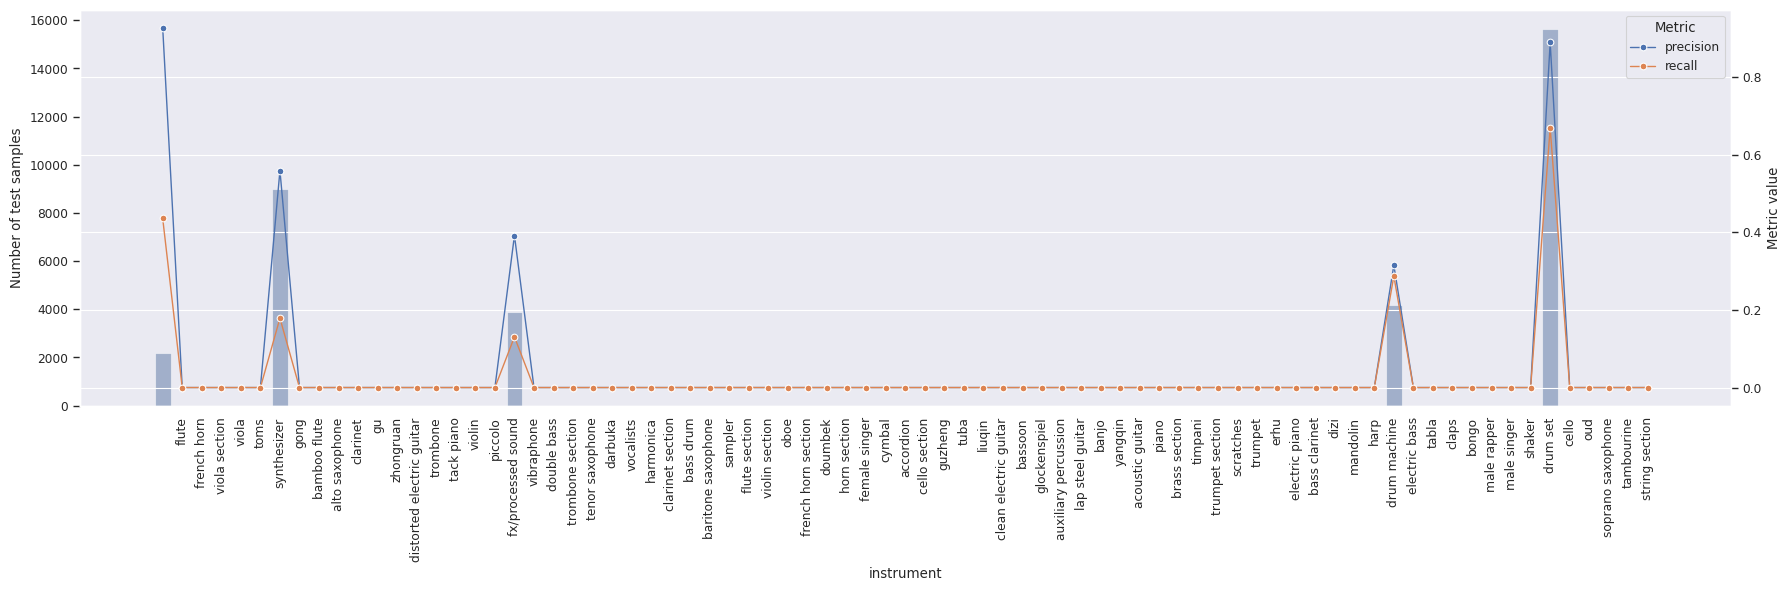

In [45]:
plt.figure(figsize=(18, 6))
sns.set_theme("paper")
sns.set_context("paper")

ax = sns.barplot(data=df, x="instrument", y="test_frame_count", color="b", alpha=0.5)
ax.set_ylabel("Number of test samples")
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df["instrument"], rotation=90)
ax.grid(False)

ax2 = ax.twinx()
df_plot = df.melt(id_vars="instrument", value_vars=["precision", "recall"], var_name="Metric", value_name="Metric value")
sns.lineplot(data=df_plot, x="instrument", y="Metric value", hue="Metric", ax=ax2, linewidth=1, marker="o")
ax2.set_ylabel("Metric value")

plt.tight_layout()
plt.show()